In [1]:
import cv2
import pandas as pd
import numpy as np
import scipy 
import matplotlib.pyplot as plt
from matplotlib import colormaps as cmps
import scipy.io as sio
from PIL import Image
import scipy.signal as signal
import pdb
from PIL import Image
import librosa           # Beat detection, BPM analysis
import statistics
import moviepy

In [2]:
from thresholding import *
from vfx import * 
from beatmatcher import *
from videoloading import *

In [3]:
%load_ext autoreload 
%autoreload 2

In [4]:
#images = []
#for img in range(len(np.array(TestCelImg))):
#    imgChannels = []
#    for channel in range(len(np.array(TestCelImg)[0,0])):
#        imgChannels.append(cartoonify(np.array(TestCelImg)[:,:,channel], 'Sobel', display=False))
        #axs[channel].imshow(cv2.threshold(frame[:,:,channel], lower_range, upper_range, binary_thresholding_options[thresholdoption])[1], cmap=colormapChannels[colorMap][channel]) ### FIND A WAY TO RANDOMISE THE LOWER THRESHOLD 
    #     imgChannels.append(cv2.threshold(frame[:,:,channel], lower_range, upper_range, binary_thresholding_options[thresholdoption])[1])### FIND A WAY TO RANDOMISE THE LOWER THRESHOLD         

    #     bgr = cv2.merge((imgChannels[2], imgChannels[1], imgChannels[0]))
#    rgb = cv2.merge((imgChannels[0], imgChannels[1], imgChannels[2]))
#    images.append(Image.fromarray(rgb))
    #     return rgb
    #         ### WITHIN A CERTAIN RANGE 

In [48]:
randomiserBounds = {
    
    'downscale': [1, 4],
    'colorOffset': [0, 5]
}


def configRandomisers(mode, imgArray):
    randomArray = np.random.randint(randomiserBounds[mode][0], randomiserBounds[mode][1], size=len(imgArray))
    highindices = np.where(randomArray>=randomiserBounds['colorOffset'][1]*0.85)
    lowindices = np.where(randomArray<=randomiserBounds['colorOffset'][1]*0.15)
    
    for index in highindices:
        try:
            randomArray[index-2] = np.ceil(randomiserBounds[mode][0], randomArray[index]-8)
            randomArray[index-1] = np.ceil(randomiserBounds[mode][0], randomArray[index]-4)
            randomArray[index+2] = np.ceil(randomiserBounds[mode][0], randomArray[index]-8)
            randomArray[index+1] = np.ceil(randomiserBounds[mode][0], randomArray[index]-4)
        except IndexError:
            continue

    
    
#     for index in lowindices:
#         try:
#             randomArray[index-2] = np.floor(randomiserBounds[mode][1], randomArray[index]+8)
#             randomArray[index-1] = np.floor(randomiserBounds[mode][1], randomArray[index]+4)
#             randomArray[index+2] = np.floor(randomiserBounds[mode][1], randomArray[index]+4)
#             randomArray[index+1] = np.floor(randomiserBounds[mode][1], randomArray[index]+8)
#         except IndexError:
#             continue

    return randomArray
    

In [49]:
imageList = extend_image_to_array('Video Assets (INPUT)/Supermarket Poplar.mp4', 'Audio Assets (INPUT)/JETPACK VIDEO.wav', 100)


In [50]:
configRandomisers('colorOffset', imageList)

array([0, 0, 4, 1, 0, 3, 1, 4, 2, 4, 0, 2, 1, 1, 2, 4, 2, 1, 2, 1, 4, 1,
       0, 4, 2, 4, 2, 2, 2, 1, 1, 1, 1, 0, 1, 3, 1, 3, 4, 3, 1, 3, 2, 3,
       1, 2, 2, 4, 3, 3, 0, 4, 0, 3, 2, 4, 2, 0, 1, 0, 3, 2, 1, 4, 2, 0,
       3, 3, 3, 0, 3, 2, 4, 1, 0, 2, 3, 0, 0, 2, 0, 0, 4, 2, 0, 2, 4, 0,
       2, 4, 4, 1, 1, 3, 4, 4, 3, 0, 3])

In [66]:
def closed_interface(videoPath, renderOption, 
                     audioMatchBool, edgeDetectBool, thresholdBool, 
                     output_path, audioPath='Audio Assets (INPUT)/JETPACK VIDEO.wav', 
                     upper_range=255, lower_range=177, 
                     thresholdoption='1', frame_interval=2
                    ):
        
        
    if renderOption == "VidConvert":
        
        print("")
        print("Launching VidConvert...")
        
        filePaths = []
        
        imageList = video_to_image_array(videoPath, audioPath, frame_interval=frame_interval)
        scaleRandomisers = configRandomisers('downscale', imageList)
        offsetRandomisers = configRandomisers('colorOffset', imageList)
        
        print("Images loaded and randomisers set. Applying thresholds...")
        
        for image in range(len(imageList)):
            r, g, b = split_rgb_frame(imageList[image])
            ###CONVERT TO DICT
            
            ### ---- THRESHOLDING AND  ----
            b = applyThreshold(Image.fromarray(cartoonify(np.array(b), edgeDetectBool)), thresholdBool, upper_range=upper_range, lower_range=lower_range, thresholdoption=thresholdoption)
            g = applyThreshold(Image.fromarray(cartoonify(np.array(g), edgeDetectBool)), thresholdBool, upper_range=upper_range, lower_range=lower_range, thresholdoption=thresholdoption)
            r = applyThreshold(Image.fromarray(cartoonify(np.array(r), edgeDetectBool)), thresholdBool, upper_range=upper_range, lower_range=lower_range, thresholdoption=thresholdoption)

            rgb = Image.fromarray(cv2.merge((np.array(r), np.array(g), np.array(b))))
            rgb = colorOffset_fullImg(rgb, strength = offsetRandomisers[image])
            rgb = downscaleImg(rgb, strength = scaleRandomisers[image])
            
            rgb.save(f"temp/tempFrame_{image}.jpeg")
            filePaths.append(f"temp/tempFrame_{image}.jpeg")
        
            imageList[image] = rgb
            
        print("Filtering complete - compiling into video...")
        
        clip = moviepy.ImageSequenceClip([f"{img}" for img in filePaths], fps = 1/float(get_audio_report(audioPath)[3])*6)
        
        clip.write_videofile(output_path)
        
        
    
    return rgb

In [67]:
def colorOffset_fullImg(inputImg, strength=5):
    r, g, b = split_rgb_frame(inputImg)
    b_shift = np.roll(b, strength, axis=0)
    g_shift = np.roll(g, strength*-1, axis=1)
    r_shift = np.roll(r, strength, axis=1)
    background = cv2.merge([b_shift, g_shift, r_shift])
    
    return Image.fromarray(background)

def downscaleImg(inputImg, strength=4):
    h, w = np.array(inputImg).shape[:2]
    outputImg = cv2.resize(np.array(inputImg), (w//strength, h//strength), interpolation=cv2.INTER_LINEAR)
    outputImg = cv2.resize(outputImg, (w, h), interpolation=cv2.INTER_NEAREST)
    
    return Image.fromarray(outputImg)

In [88]:
acceptedRenders = {
    
    "Balfron": {
        "Version1": ["Video Assets (INPUT)/Balfron.mp4", "VidConvert", "N", "Sobel", "N", "BalfronV1.mp4"],
        "Version2": ["Video Assets (INPUT)/Balfron.mp4", "VidConvert", "N", "Sobel", "Binary", "BalfronV2.mp4", 'Audio Assets (INPUT)/JETPACK VIDEO.wav', 175, 127, '3'],
        "Version3": ["Video Assets (INPUT)/Balfron.mp4", "VidConvert", "N", "N", "Binary", "BalfronV3.mp4", 'Audio Assets (INPUT)/JETPACK VIDEO.wav', 175, 127, '5']
    },
    
    "SouthBankSkater": {
        "Version1": ["Video Assets (INPUT)/southBankSkater.mp4", "VidConvert", "N", "Sobel", "N", "SBSkaterV1.mp4"], 
    }
    
}




Launching VidConvert...
Images loaded and randomisers set. Applying thresholds...
Filtering complete - compiling into video...
MoviePy - Building video SBSkaterV1.mp4.
MoviePy - Writing video SBSkaterV1.mp4



MoviePy - Done !
MoviePy - video ready SBSkaterV1.mp4


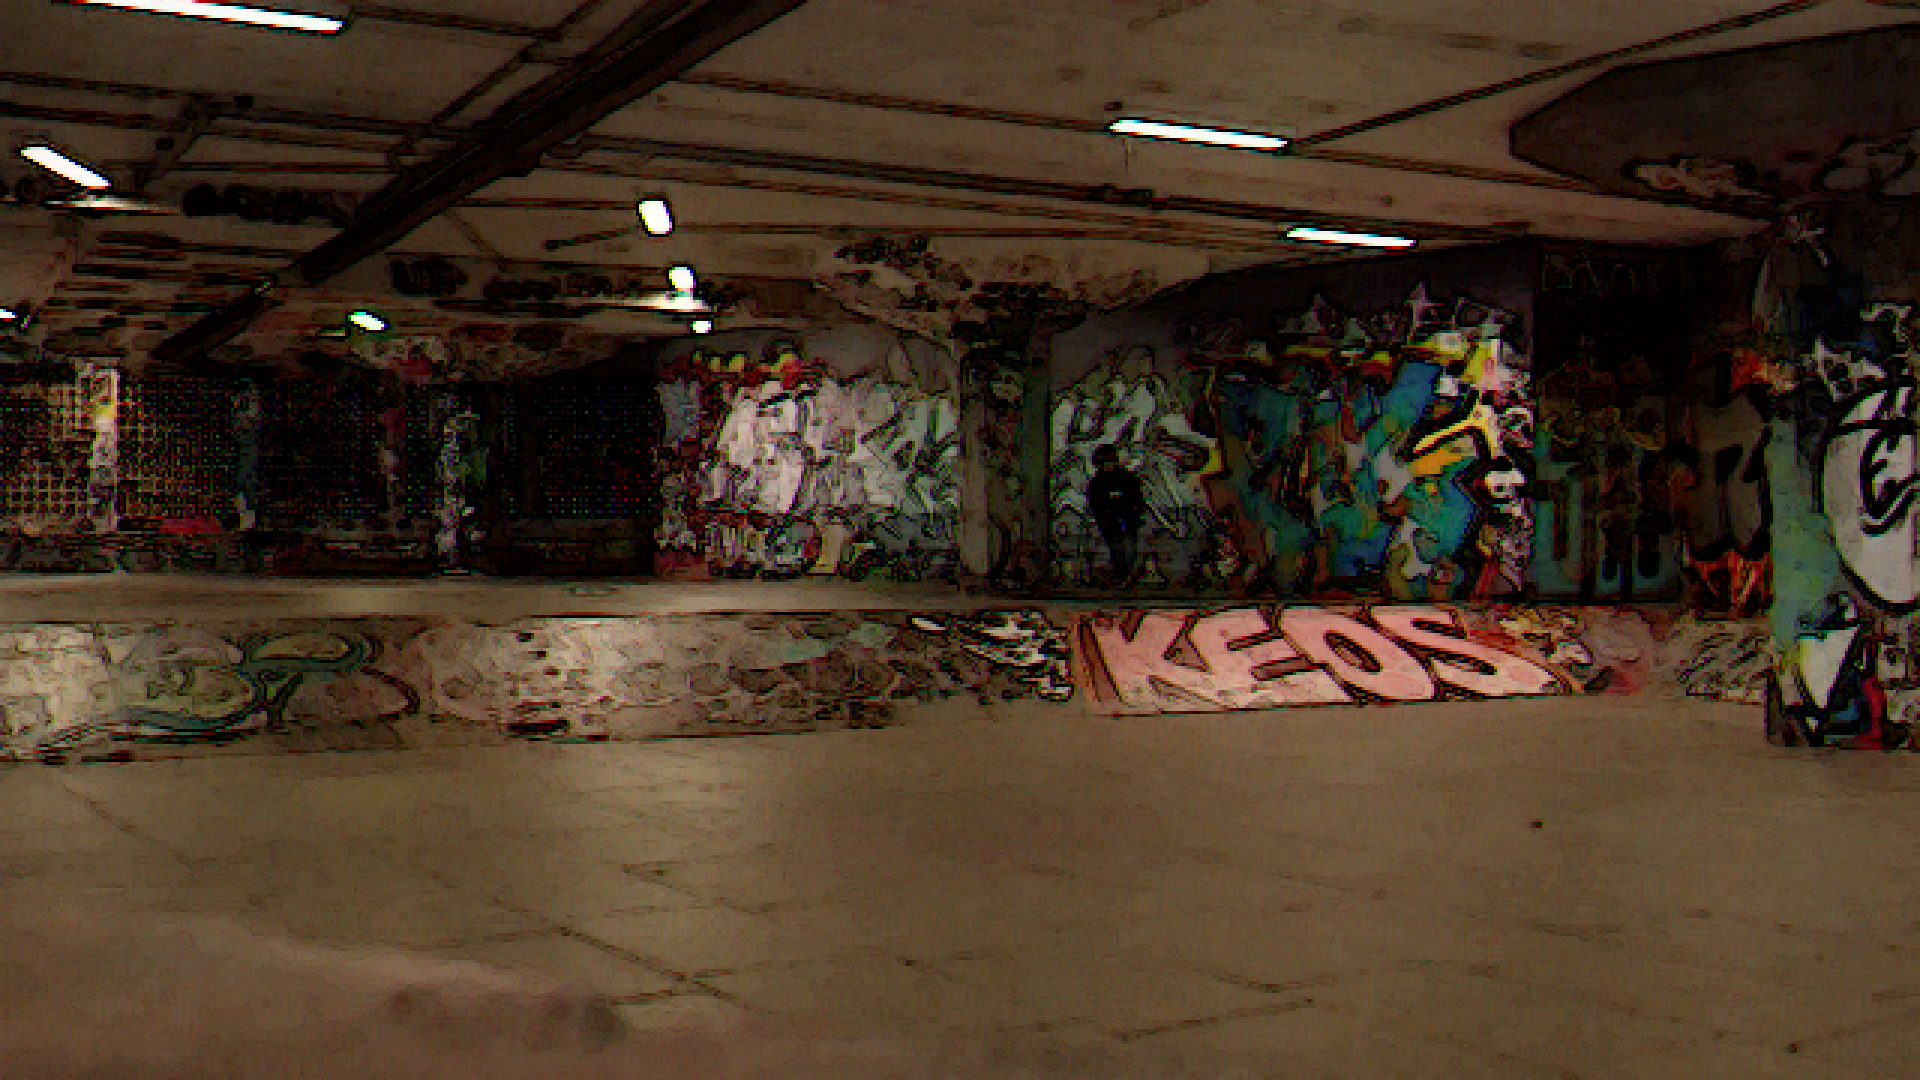

In [89]:
closed_interface(*acceptedRenders['SouthBankSkater']['Version1'])

In [17]:
def interactive_interface():
    
    videoPath = input("Please enter the path to the image/video to be rendered: ")
    renderOption = input("Please select a render option: (ArrayExtend / VidConvert)")
    audioMatchBool = input("Enter an audio path now for beat matching? (Y/N)")
    edgeDetectBool = input("Apply Edge Detection Algorithm? (Sobel/Laplacian/N)")
    thresholdBool = input("Apply Thresholding Algorithm? (Binary/Adaptive/N)")
    
    if audioMatchBool == 'Y' or audioMatchBool == 'y':
        audioPath = input("Please enter the path to the image/video to be rendered: ")
    else:
        audioPath = None     
        
    if renderOption == "VidConvert":
        
        print("")
        print("Launching VidConvert...")
        
        filePaths = []
        
        imageList = video_to_image_array(videoPath, 'Audio Assets (INPUT)/JETPACK VIDEO.wav', frame_interval=2)
        for image in range(len(imageList)):
            r, g, b = split_rgb_frame(imageList[image])
        ###CONVERT TO DICT
            b = applyThreshold(Image.fromarray(cartoonify(np.array(b), edgeDetectBool)), thresholdBool)
            g = applyThreshold(Image.fromarray(cartoonify(np.array(g), edgeDetectBool)), thresholdBool)
            r = applyThreshold(Image.fromarray(cartoonify(np.array(r), edgeDetectBool)), thresholdBool)

            rgb = Image.fromarray(cv2.merge((np.array(b), np.array(g), np.array(r))))
            rgb.save(f"temp/tempFrame_{image}.jpeg")
            filePaths.append(f"temp/tempFrame_{image}.jpeg")
        
            imageList[image] = rgb
        
        clip = moviepy.ImageSequenceClip([f"{img}" for img in filePaths], fps = 1/float(0.3947392290249425)*3)
        clip.write_videofile('TESTINTERACT.mp4')
        
    print(f"If you like this render, copy the following list: [{videoPath}, {renderOption}, {audioMatchBool}, {edgeDetectBool}, {thresholdBool}]")
    
    return rgb

In [7]:
rgb = interactive_interface()

Please enter the path to the image/video to be rendered: Video Assets (INPUT)/TEST - PERSON TRACKER SHOREDITCH.mp4
Please select a render option: (ArrayExtend / VidConvert)VidConvert
Enter an audio path now for beat matching? (Y/N)N
Apply Edge Detection Algorithm? (Sobel/Laplacian/N)Sobel
Apply Thresholding Algorithm? (Binary/Adaptive/N)N

Launching VidConvert...
MoviePy - Building video TESTINTERACT.mp4.
MoviePy - Writing video TESTINTERACT.mp4



MoviePy - Done !
MoviePy - video ready TESTINTERACT.mp4


In [20]:
INTERIMimageList = video_to_image_array('Video Assets (INPUT)/TEST - PERSON TRACKER SHOREDITCH.mp4', 'Audio Assets (INPUT)/JETPACK VIDEO.wav', frame_interval=2)

#imageList = extend_image_to_array('Video Assets (INPUT)/Supermarket Poplar.mp4', 'Audio Assets (INPUT)/JETPACK VIDEO.wav', 100)


In [43]:
get_audio_report('Audio Assets (INPUT)/JETPACK VIDEO.wav')

(array([151.99908088]),
 array([  70,  104,  137,  173,  207,  241,  275,  310,  344,  378,  412,
         446,  481,  515,  549,  583,  618,  652,  686,  720,  755,  789,
         823,  857,  892,  925,  960,  994, 1029, 1063, 1097, 1131, 1166,
        1199, 1225, 1251, 1285, 1319, 1353, 1388, 1422, 1456, 1490, 1525,
        1559, 1593, 1627, 1661, 1696, 1730, 1764, 1798, 1833, 1867, 1901,
        1935, 1970, 2004, 2038, 2072, 2106, 2141, 2175, 2209, 2243]),
 array([ 0.81269841,  1.20743764,  1.59056689,  2.00852608,  2.40326531,
         2.79800454,  3.19274376,  3.59909297,  3.9938322 ,  4.38857143,
         4.78331066,  5.17804989,  5.58439909,  5.97913832,  6.37387755,
         6.76861678,  7.17496599,  7.56970522,  7.96444444,  8.35918367,
         8.76553288,  9.16027211,  9.55501134,  9.94975057, 10.35609977,
        10.73922902, 11.14557823, 11.54031746, 11.94666667, 12.3414059 ,
        12.73614512, 13.13088435, 13.53723356, 13.92036281, 14.22222222,
        14.52408163, 14.9

In [126]:
#### ---- GENERIC PRESET TO EXPLORE OPTIONS WITH FULL RANDOMISER ---- ####
# filePaths = []
# fig, axs = plt.subplots(len(imageList), figsize=(128, 128))
# for image in range(len(imageList)):
#     binaryThresholdingV2(imageList[image], lower_range=np.random.randint(140, 189), upper_range=np.random.randint(230, 255), thresholdoption=str(np.random.randint(1, 6)))


#### ---- SAVED PRESET 1 (CABLE STREET MINI SUPERMARKET) ---- ####
#filePaths = []
#fig, axs = plt.subplots(len(INTERIMimageList), figsize=(128, 128))
#for image in range(len(INTERIMimageList)):
#    filePaths.append(binaryThresholdingV2(INTERIMimageList[image], frame_number=image, lower_range=np.random.randint(174, 189), upper_range=np.random.randint(240, 248), thresholdoption='5', save=True, vis=True)[1])
    

In [22]:
clip = moviepy.ImageSequenceClip([f"{img}" for img in filePaths], fps = 1/float(frame_rate)*5)
clip.write_videofile('shoreditch.mp4')

MoviePy - Building video shoreditch.mp4.
MoviePy - Writing video shoreditch.mp4



MoviePy - Done !
MoviePy - video ready shoreditch.mp4


#### Next Ideas

#### Chromatic abberation - 

5. Channel Offsets (PSX jitter)

To mimic the PlayStation’s affine texture warping:

Duplicate the layer 2 times.

Set each to target one color channel:

Red layer: keep only red channel active.

Green layer: only green.

Blue layer: only blue.

Slightly nudge each channel (1–3 px) in random directions.

Merge back together.

This creates a subtle RGB “swim” effect.

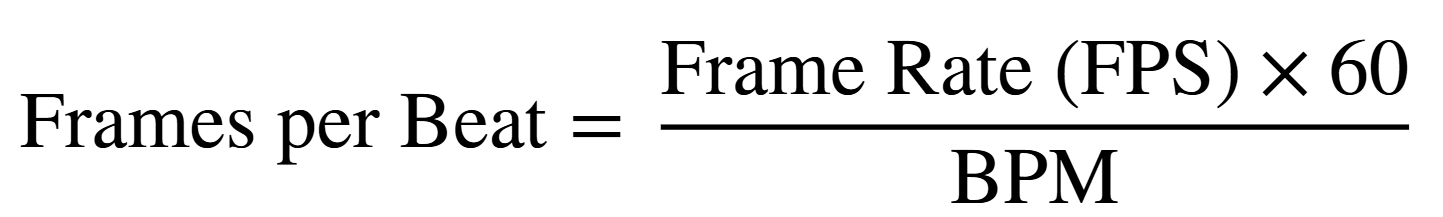